In [1]:
#  0.1

import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

print("Project root added to path:", PROJECT_ROOT)


Project root added to path: C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Health Imaging


In [2]:
# 0.2

from src.config import (
    IMG_DIR,
    LABELS_PATH,
    RANDOM_SEED,
    IMAGE_SIZE,
    BATCH_SIZE,
    PATHOLOGY_LABELS,
)

print("Images dir:", IMG_DIR)
print("Labels file:", LABELS_PATH)


Images dir: C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Health Imaging\data\sample\images
Labels file: C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Health Imaging\data\sample\sample_labels.csv


In [3]:

# 1.0 Imports



import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




C:\Users\k1tty\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:

# 2.1 Load metadata & build master dataframe


# load labels CSV
labels_df = pd.read_csv(LABELS_PATH)

# rename columns for convenience
labels_df = labels_df.rename(columns={
    "Image Index": "image_id",
    "Patient ID": "patient_id",
    "Finding Labels": "finding_labels"
})

# binary pathology indicator
labels_df["has_pathology"] = labels_df["finding_labels"] != "No Finding"

# build image paths using pathlib (NO strings, NO os.path)
labels_df["image_path"] = labels_df["image_id"].apply(lambda x: IMG_DIR / x)

# final master dataframe
health_df = labels_df[[
    "image_id",
    "image_path",
    "patient_id",
    "finding_labels",
    "has_pathology"
]].copy()

health_df.head()


,image_id,image_path,patient_id,finding_labels,has_pathology
0,00000013_005.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,13,Emphysema|Infiltration|Pleural_Thickening|Pneu...,True
1,00000013_026.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,13,Cardiomegaly|Emphysema,True
2,00000017_001.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,17,No Finding,False
3,00000030_001.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,30,Atelectasis,True
4,00000032_001.png,C:\Users\k1tty\OneDrive\Desktop\Uni - MSc\Heal...,32,Cardiomegaly|Edema|Effusion,True


Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Pleural_Thickening    176
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
dtype: int64

Atelectasis           0
Cardiomegaly          0
Effusion              0
Infiltration          0
Mass                  0
Nodule                0
Pneumonia             0
Pneumothorax          0
Consolidation         0
Edema                 0
Emphysema             0
Fibrosis              0
Pleural_Thickening    0
Hernia                0
dtype: int64

np.True_

Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Pleural_Thickening    176
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
dtype: int64

Infiltration          0.172494
Effusion              0.114877
Atelectasis           0.090617
Nodule                0.055833
Mass                  0.050660
Pneumothorax          0.048341
Consolidation         0.040314
Pleural_Thickening    0.031395
Cardiomegaly          0.025152
Emphysema             0.022654
Edema                 0.021049
Fibrosis              0.014984
Pneumonia             0.011060
Hernia                0.002319
dtype: float64

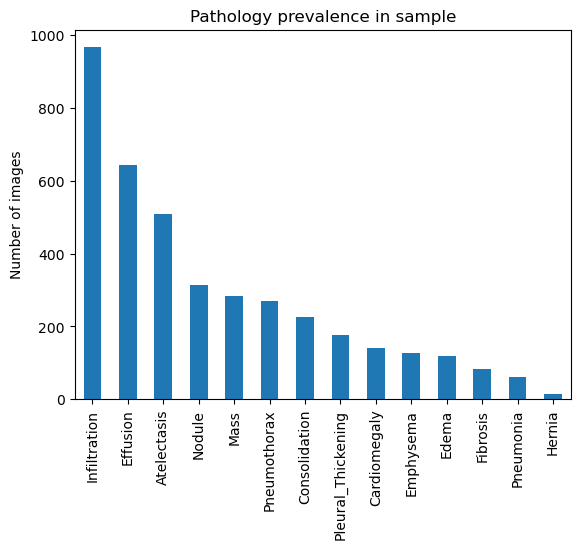

No Finding
1    3044
0    2562
Name: count, dtype: int64

np.float64(0.5429896539422048)

np.float64(0.4570103460577952)

,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
Atelectasis,508,15,151,130,26,25,11,32,56,11,20,13,20,5
Cardiomegaly,15,141,57,25,6,4,3,2,11,8,4,4,4,0
Effusion,151,57,644,173,54,46,8,52,63,25,24,12,38,2
Infiltration,130,25,173,967,54,75,23,42,57,46,20,14,33,2
Mass,26,6,54,54,284,44,4,34,28,5,13,6,23,3
Nodule,25,4,46,75,44,313,6,25,14,4,5,5,18,0
Pneumonia,11,3,8,23,4,6,62,2,12,14,3,0,1,0
Pneumothorax,32,2,52,42,34,25,2,271,12,1,34,2,17,1
Consolidation,56,11,63,57,28,14,12,12,226,8,4,4,14,0
Edema,11,8,25,46,5,4,14,1,8,118,1,1,0,0


In [6]:
# ============================================================
# 3.1 Feature engineering — mean image intensity (baseline)
# ============================================================

def mean_intensity(path):
    img = Image.open(path).convert("L")
    return np.array(img).mean()

health_df["mean_intensity"] = health_df["image_path"].apply(mean_intensity)

health_df.groupby("has_pathology")["mean_intensity"].describe()


,count,mean,std,min,25%,50%,75%,max
has_pathology,,,,,,,,
False,3044.0,129.196508,22.855636,37.456021,112.132777,124.206892,146.863716,195.686037
True,2562.0,124.556523,21.504938,41.294493,110.167101,120.353561,136.518867,193.426656


In [5]:
# 3.2
# split pipe-separated findings into lists
health_df["label_list"] = health_df["finding_labels"].str.split("|")


In [ ]:
# 3.3
for label in PATHOLOGY_LABELS:
    health_df[label] = health_df["label_list"].apply(
        lambda labels: int(label in labels)
    )


In [ ]:
# 3.4
health_df = health_df.drop(columns=["label_list"])


In [ ]:

# 3.5
health_df["No Finding"] = (
    health_df[PATHOLOGY_LABELS].sum(axis=1) == 0
).astype(int)


In [9]:
# ============================================================
# 4. Patient-level train / validation split
# ============================================================

gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_STATE
)

train_idx, val_idx = next(
    gss.split(
        health_df,
        health_df["has_pathology"],
        groups=health_df["patient_id"]
    )
)

train_df = health_df.iloc[train_idx].copy()
val_df = health_df.iloc[val_idx].copy()

train_df["has_pathology"].value_counts(normalize=True), \
val_df["has_pathology"].value_counts(normalize=True)


(has_pathology
 False    0.535786
 True     0.464214
 Name: proportion, dtype: float64,
 has_pathology
 False    0.571811
 True     0.428189
 Name: proportion, dtype: float64)

In [ ]:
#4.0
health_df["No Finding"].value_counts()






In [ ]:
# 4.0
health_df["No Finding"].mean()

In [ ]:
# 4.0
health_df["has_pathology"].mean()

In [ ]:
# 4.1
health_df[PATHOLOGY_LABELS].sum().sort_values(ascending=False)


In [ ]:
# 4.1

label_counts = health_df[PATHOLOGY_LABELS].sum().sort_values(ascending=False)
label_counts


In [ ]:
# 4.1
label_prevalence = label_counts / len(health_df)
label_prevalence


In [ ]:
# 4.3

label_counts.plot(kind="bar")
plt.ylabel("Number of images")
plt.title("Pathology prevalence in sample")
plt.show()


In [ ]:
# 4.4
co_occurrence = health_df[PATHOLOGY_LABELS].T @ health_df[PATHOLOGY_LABELS]
co_occurrence


In [10]:
# ============================================================
# 5. Baseline model — Logistic Regression (mean intensity)
# ============================================================

X_train = train_df[["mean_intensity"]].values
y_train = train_df["has_pathology"].astype(int).values

X_val = val_df[["mean_intensity"]].values
y_val = val_df["has_pathology"].astype(int).values

baseline_lr = LogisticRegression(max_iter=1000)
baseline_lr.fit(X_train, y_train)

y_val_prob_lr = baseline_lr.predict_proba(X_val)[:, 1]
y_val_pred_lr = (y_val_prob_lr >= 0.5).astype(int)

print("Baseline (mean intensity) classification report:")
print(classification_report(y_val, y_val_pred_lr, zero_division=0))
print("Baseline ROC–AUC:", roc_auc_score(y_val, y_val_prob_lr))


Baseline (mean intensity) classification report:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       641
           1       0.45      0.25      0.32       480

    accuracy                           0.55      1121
   macro avg       0.51      0.51      0.49      1121
weighted avg       0.52      0.55      0.52      1121

Baseline ROC–AUC: 0.5578653146125845


In [ ]:
# 4.2
health_df.loc[health_df["No Finding"] == 1, PATHOLOGY_LABELS].sum()


In [ ]:
# 4.2
(health_df["has_pathology"] == (health_df["No Finding"] == 0)).all()


In [11]:
# ============================================================
# 6. TensorFlow input pipeline (RGB, EfficientNet-compatible)
# ============================================================

def load_and_preprocess_image_rgb(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.grayscale_to_rgb(img)
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["image_path"].values,
     train_df["has_pathology"].astype(int).values)
)

train_ds = (
    train_ds
    .map(load_and_preprocess_image_rgb, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["image_path"].values,
     val_df["has_pathology"].astype(int).values)
)

val_ds = (
    val_ds
    .map(load_and_preprocess_image_rgb, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [12]:
# ============================================================
# 7. Class weights (train only)
# ============================================================

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=train_df["has_pathology"].astype(int).values
)

class_weight = {0: float(weights[0]), 1: float(weights[1])}
class_weight


{0: 0.9332084893882646, 1: 1.0770893371757926}

In [13]:
# ============================================================
# 8. CNN — baseline (from scratch, RGB)
# ============================================================

cnn_baseline = keras.Sequential(
    name="cnn_baseline",
    layers=[
        layers.Conv2D(32, 3, activation="relu", input_shape=(224,224,3)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ]
)

cnn_baseline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

cnn_baseline.summary()


C:\Users\k1tty\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# ============================================================
# 9. Train CNN baseline
# ============================================================

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,
    restore_best_weights=True
)

history_baseline = cnn_baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weight
)


Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - auc: 0.5112 - loss: 0.6933 - precision: 0.4691 - recall: 0.5615 - val_auc: 0.5000 - val_loss: 0.6962 - val_precision: 0.4282 - val_recall: 1.0000
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - auc: 0.5028 - loss: 0.6932 - precision: 0.4659 - recall: 0.5615 - val_auc: 0.5120 - val_loss: 0.6948 - val_precision: 0.4282 - val_recall: 1.0000
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - auc: 0.5226 - loss: 0.6929 - precision: 0.4766 - recall: 0.6354 - val_auc: 0.5393 - val_loss: 0.6986 - val_precision: 0.4282 - val_recall: 1.0000
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - auc: 0.5149 - loss: 0.6929 - precision: 0.4776 - recall: 0.6393 - val_auc: 0.5469 - val_loss: 0.6914 - val_precision: 0.4430 - val_recall: 0.4854
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - auc: 0.5339 - loss: 0.6918 - precision: 0.4876 - recall: 0.5086 - val_auc: 0.5465 - val_loss: 0.6932 - val_precision: 0.4659 - val_recall: 0.

In [15]:
# ============================================================
# 10. Evaluate CNN baseline
# ============================================================

val_metrics = cnn_baseline.evaluate(val_ds, return_dict=True)
val_metrics

y_val_true = np.concatenate([y.numpy() for _, y in val_ds])
y_val_prob = cnn_baseline.predict(val_ds).ravel()
y_val_pred = (y_val_prob >= 0.5).astype(int)

print(classification_report(y_val_true, y_val_pred, zero_division=0))
print("ROC–AUC:", roc_auc_score(y_val_true, y_val_prob))


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - auc: 0.6110 - loss: 0.6769 - precision: 0.5375 - recall: 0.4625
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 581ms/step
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       641
           1       0.54      0.46      0.50       480

    accuracy                           0.60      1121
   macro avg       0.59      0.58      0.58      1121
weighted avg       0.59      0.60      0.59      1121

ROC–AUC: 0.6104686687467499


In [16]:
# ============================================================
# 11. Transfer learning — EfficientNetB0 (frozen)
# ============================================================

base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False

inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

cnn_tl = keras.Model(inputs, outputs, name="cnn_tl")

cnn_tl.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

cnn_tl.summary()


Model: "cnn_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
# ============================================================
# 12. Train & evaluate transfer learning model
# ============================================================

history_tl = cnn_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight
)

val_metrics_tl = cnn_tl.evaluate(val_ds, return_dict=True)
val_metrics_tl


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - auc: 0.5122 - loss: 0.7000 - precision: 0.4699 - recall: 0.5783 - val_auc: 0.5000 - val_loss: 0.6922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - auc: 0.5044 - loss: 0.6933 - precision: 0.4703 - recall: 0.3305 - val_auc: 0.5000 - val_loss: 0.6938 - val_precision: 0.4282 - val_recall: 1.0000
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - auc: 0.4935 - loss: 0.6938 - precision: 0.4651 - recall: 0.5696 - val_auc: 0.5000 - val_loss: 0.6952 - val_precision: 0.4282 - val_recall: 1.0000
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - auc: 0.5171 - loss: 0.6929 - precision: 0.4803 - recall: 0.6686 - val_auc: 0.5000 - val_loss: 0.6964 - val_precision: 0.4282 - val_recall: 1.0000
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 793s 6s/step - auc: 0.4960 - loss: 0.6933 - precision: 0.4642 - recall: 1.0000 - val_auc: 0.5000 - val_loss: 0.6944 - val_precision: 0.4282 - val_re

{'auc': 0.5, 'loss': 0.6921689510345459, 'precision': 0.0, 'recall': 0.0}

**PATHOLOGY INVESTIGATION**

In [18]:
# list pathologies

pathologies = [
    "Effusion",
    "Atelectasis",
    "Cardiomegaly",
    "Pneumothorax"
]


In [19]:
# create function 

def run_pathology_experiment(pathology):

    print(f"\n===== Running experiment for {pathology} =====")

    # --- build pathology df ---
    patho_df = health_df[health_df["has_pathology"]].copy()
    patho_df["target"] = (
        patho_df["finding_labels"]
        .fillna("")
        .str.contains(pathology, regex=False)
        .astype(int)
    )

    # --- patient split ---
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=19)
    train_idx, val_idx = next(
        gss.split(patho_df, patho_df["target"], groups=patho_df["patient_id"])
    )

    train_df = patho_df.iloc[train_idx]
    val_df   = patho_df.iloc[val_idx]

    # --- baseline LR ---
    lr = LogisticRegression(max_iter=1000)
    lr.fit(train_df[["mean_intensity"]], train_df["target"])

    y_val_prob_lr = lr.predict_proba(val_df[["mean_intensity"]])[:, 1]
    auc_lr = roc_auc_score(val_df["target"], y_val_prob_lr)

    # --- return summary only (keep it light) ---
    return {
        "pathology": pathology,
        "n_samples": len(patho_df),
        "positive_rate": patho_df["target"].mean(),
        "baseline_auc": auc_lr
    }


In [20]:
# loop once and collect results

results = []

for p in pathologies:
    results.append(run_pathology_experiment(p))

results_df = pd.DataFrame(results)
results_df



===== Running experiment for Effusion =====

===== Running experiment for Atelectasis =====

===== Running experiment for Cardiomegaly =====

===== Running experiment for Pneumothorax =====


,pathology,n_samples,positive_rate,baseline_auc
0,Effusion,2562,0.251366,0.528287
1,Atelectasis,2562,0.198283,0.543515
2,Cardiomegaly,2562,0.055035,0.451657
3,Pneumothorax,2562,0.105777,0.562143


**Pathology-specific baseline analysis**

A simple baseline classifier using global mean image intensity was evaluated separately for four common thoracic pathologies. Performance varied substantially by condition, with ROC–AUC values ranging from 0.45 (Cardiomegaly) to 0.56 (Pneumothorax). This variability reflects differences in how each pathology manifests radiographically; conditions such as pneumothorax can induce large global intensity changes, whereas cardiomegaly primarily alters spatial structure rather than pixel intensity.

Overall, these results indicate that global image statistics provide limited and pathology-dependent discriminative power, motivating the use of convolutional models capable of capturing spatially localised features.

In [21]:
pathologies = [
    "Effusion",
    "Atelectasis",
    "Cardiomegaly",
    "Pneumothorax"
]


In [22]:
def run_cnn_pathology(pathology):

    print(f"\n===== CNN experiment: {pathology} =====")

    # ---------------------------
    # Build pathology dataframe
    # ---------------------------
    patho_df = health_df[health_df["has_pathology"]].copy()

    patho_df["target"] = (
        patho_df["finding_labels"]
        .fillna("")
        .str.contains(pathology, regex=False)
        .astype(int)
    )

    # ---------------------------
    # Patient-level split
    # ---------------------------
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=19)
    train_idx, val_idx = next(
        gss.split(
            patho_df,
            patho_df["target"],
            groups=patho_df["patient_id"]
        )
    )

    train_df = patho_df.iloc[train_idx].copy()
    val_df   = patho_df.iloc[val_idx].copy()

    # ---------------------------
    # TF datasets
    # ---------------------------
    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_df["image_path"].values,
         train_df["target"].values)
    ).map(load_and_preprocess_image_rgb, num_parallel_calls=AUTOTUNE) \
     .shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_df["image_path"].values,
         val_df["target"].values)
    ).map(load_and_preprocess_image_rgb, num_parallel_calls=AUTOTUNE) \
     .batch(batch_size).prefetch(AUTOTUNE)

    # ---------------------------
    # Class weights
    # ---------------------------
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0, 1]),
        y=train_df["target"].values
    )

    class_weight = {0: float(weights[0]), 1: float(weights[1])}

    # ---------------------------
    # Model
    # ---------------------------
    base_model = keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224,224,3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs,
        outputs,
        name=f"cnn_tl_{pathology.lower()}"
    )

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )

    # ---------------------------
    # Train
    # ---------------------------
    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    )

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[early_stop],
        class_weight=class_weight,
        verbose=0
    )

    # ---------------------------
    # Evaluate
    # ---------------------------
    y_val_true = np.concatenate([y.numpy() for _, y in val_ds])
    y_val_prob = model.predict(val_ds).ravel()

    auc = roc_auc_score(y_val_true, y_val_prob)

    return {
        "pathology": pathology,
        "n_samples": len(patho_df),
        "positive_rate": patho_df["target"].mean(),
        "cnn_auc": auc
    }


In [23]:
cnn_results = []

for p in pathologies:
    cnn_results.append(run_cnn_pathology(p))

cnn_results_df = pd.DataFrame(cnn_results)
cnn_results_df



===== CNN experiment: Effusion =====
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step 

===== CNN experiment: Atelectasis =====
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step 

===== CNN experiment: Cardiomegaly =====
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step 

===== CNN experiment: Pneumothorax =====
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step 


,pathology,n_samples,positive_rate,cnn_auc
0,Effusion,2562,0.251366,0.526718
1,Atelectasis,2562,0.198283,0.489461
2,Cardiomegaly,2562,0.055035,0.453975
3,Pneumothorax,2562,0.105777,0.610323


In [25]:
for pathology in pathologies:
    val_metrics_(pathology) == cnn_tl.evaluate(val_ds, return_dict=True)
    val_metrics_(pathology)

NameError: name 'val_metrics_' is not defined